In [11]:
# Import the neccessary libraries.
import os
import torch
from torch import nn
from torch.nn import functional as nn_func
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transforms_v2
from torchvision import datasets
import torch.optim as optim
import matplotlib.pyplot as plt

# Implementation of the MobileNet architecture from scracth. 

In [2]:
class DepthSeptConvBlock(nn.Module):
    """
    Depthwise Separable Convolution Block.

    This block performs depthwise separable convolutions, which consist of:
    1. A depthwise convolution: Applies a separate 3x3 convolutional filter for each input channel.
    2. A pointwise convolution: Applies a 1x1 convolution to mix the features from the depthwise convolution.

    The block includes batch normalization and ReLU activation applied after each convolution.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int, optional): Stride of the depthwise convolution. Default is 1.
    """

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # Depthwise convolution followed by batch normalization and ReLU activation.
        self.depthwise_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels,
                      kernel_size=3,
                      stride=stride,
                      groups=in_channels,
                      padding=1),
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(inplace=True)
        )

        # Pointwise convolution followed by batch normalization and ReLU activation.
        self.pointwise_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=1,
                      stride=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the Depthwise Separable Convolution Block.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, in_channels, height, width).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, out_channels, height, width).
        """
        x = self.depthwise_layer(x)
        x = self.pointwise_layer(x)

        return x

print("The Depthwise Separable Convolutions block defined!")

The Depthwise Separable Convolutions block defined!


In [3]:
class MobileNet(nn.Module):
    """
    MobileNet Architecture from the paper "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications"


    MobileNet is a lightweight deep learning model designed for efficient inference on mobile and edge devices.
    It uses depthwise separable convolutions to reduce the number of parameters and computational complexity.

    Args:
        out_channels (int, optional): Number of output channels for the initial convolution layer. Default is 32.
        output_size (int, optional): Size of the output features before the fully connected layer. Default is 1024.
        num_classes (int, optional): Number of classes for classification. Default is 10.
    """

    def __init__(self, out_channels=32, output_size=1024, num_classes=10):
        super().__init__()

        # Initial convolutional layer followed by batch normalization and ReLU activation.
        self.input_conv = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      kernel_size=3,
                      out_channels=out_channels,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

        # MobileNet core: sequence of depthwise separable convolution blocks.
        self.mobile_net = nn.Sequential(
            DepthSeptConvBlock(in_channels=32, out_channels=64, stride=1),
            DepthSeptConvBlock(in_channels=64, out_channels=128, stride=2),
            DepthSeptConvBlock(in_channels=128, out_channels=128, stride=1),
            DepthSeptConvBlock(in_channels=128, out_channels=256, stride=2),
            DepthSeptConvBlock(in_channels=256, out_channels=256, stride=1),
            DepthSeptConvBlock(in_channels=256, out_channels=512, stride=2),

            # Repeated (5x 512) Depthwise Separable Convolution Blocks.
            DepthSeptConvBlock(in_channels=512, out_channels=512, stride=1),
            DepthSeptConvBlock(in_channels=512, out_channels=512, stride=1),
            DepthSeptConvBlock(in_channels=512, out_channels=512, stride=1),
            DepthSeptConvBlock(in_channels=512, out_channels=512, stride=1),
            DepthSeptConvBlock(in_channels=512, out_channels=512, stride=1),

            # Additional Depthwise Separable Convolutions followed by Average Pooling.
            DepthSeptConvBlock(in_channels=512, out_channels=1024, stride=2),
            DepthSeptConvBlock(in_channels=1024, out_channels=1024, stride=2),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Fully connected layer for classification.
        self.fc = nn.Sequential(
            nn.Linear(in_features=output_size, out_features=num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the MobileNet network.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, num_classes), representing the class scores.
        """
        x = self.input_conv(x)
        x = self.mobile_net(x)

        # Flatten the output before the fully connected layer.
        x = x.view(-1, 1024)
        x = self.fc(x)
        x = nn_func.softmax(x, dim=1)

        return x

print("MobileNet architecture with depthwise separable convolutions defined!")

MobileNet architecture with depthwise separable convolutions defined!


In [4]:
torch.manual_seed(2024)

def load_MNIST_dataset():


    # Define the transformations to be performed.
    transformations = transforms_v2.Compose([
        # Resize the images.
        transforms_v2.Resize((224, 224)),

        # Random horizontal flip with a probability of 0.5
        transforms_v2.RandomHorizontalFlip(p=0.5),

        # Random rotation of the image by a given angle (degrees)
        transforms_v2.RandomRotation(degrees=30),

        # Convert images to tensors.
        transforms_v2.ToTensor(),

        # Normalize the pixel values (in RGB channels).
        transforms_v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])


    train_data = datasets.FashionMNIST(
        root="./data",
        train=True,
      transform=transformations,
      download=True
        )

    valid_data = datasets.FashionMNIST(
        root="./data",
        train=False,
        transform=transformations,
        download=True
        )

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=1)
    valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False, num_workers=1)

    return train_loader, valid_loader


train_loader, valid_loader = load_MNIST_dataset()
print("Data are loaded and are ready to use!")

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 26421880/26421880 [00:02<00:00, 10079363.02it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212264.31it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3994193.39it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10657589.83it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Data are loaded and are ready to use!


In [5]:
def train_model(device, model, train_loader, epoch, optimizer):

    # Set the model to training mode.
    model.train()
    train_loss = 0
    print(f"\nEpoch: {epoch}")

    # process the images in batches.
    for batch_idx, (data, labels) in enumerate(train_loader):
        # Use the device for hardware acceleration.
        data = data.to(device)
        label = labels.to(device)

        # Reset the optimizer.
        optimizer.zero_grad()

        # Push the data forward through the model layers.
        output = model(data)

        # Get the loss.
        loss = loss_criteria(output, label)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()
     
        # Print metrics for every 5 batches
        if batch_idx % 5 == 0:
            print(f"Training set [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100 * batch_idx / len(train_loader):.0f}%)] Loss: {loss.item():.5f} ")

    # Return the average loss for each epoch.
    avg_loss = train_loss / (batch_idx + 1)
    print(f"Average Training Loss: {avg_loss:.5f}")

    print("Training Completed!")

    return avg_loss

In [6]:
def validate_model(device, model, val_loader):
    # Switch the model to evaluation mode to see how the model is performing.
    model.eval()
    print("Model Validation Starts!")

    # Initialize the validation loss.
    val_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for data, target in val_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted class for this  batch.
            output = model(data)

            # Calculate the loss for this batch.
            val_loss += loss_criteria(output, target).item()

            # Calculate the accuracy  metrics for this batch.
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target == predicted).item()

        # Calculate the total accuracy and average loss for each epoch.
        avg_loss = val_loss / batch_count
        print(f'Average Validation Loss: {avg_loss:.5f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100 * correct / len(val_loader.dataset):.0f}%)')

        # Return average loss for each epoch.
        return avg_loss

In [9]:
# It is time to use the train function to train and the validatio function to evaluate how the model is performing.

device = "cpu"
# Check if GPU is present or avaliable as the hardware accelerator.
if (torch.cuda.is_available()):
    device = "cuda"
print(f"Training on {device}")


# Create an instance of the model class and allocate it to the device available.
model = MobileNet(num_classes=10).to(device)

# Define the learning rate.
learning_rate = 1e-4
# # Use Adaptive Moment Estimation Optimization to adjust and update the model weights.
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Using RMSProp optimizer
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

# Specify the loss criteria.
loss_criteria = nn.CrossEntropyLoss()

# Initialize empty arrays to track metrics.
epoch_nums, training_loss, validation_loss,  = [], [], []

# Train over 30 epochs.
epochs = 25
for epoch in range(1, epochs +1):
    train_loss = train_model(device, model, train_loader, epoch, optimizer)
    val_loss = validate_model(device, model, valid_loader)

    # Append the metrics to the predefined empty arrays.
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)

Training on cuda

Epoch: 1
Training set [0/60000 (0%)] Loss: 2.30418 
Training set [320/60000 (1%)] Loss: 2.26698 
Training set [640/60000 (1%)] Loss: 2.20818 
Training set [960/60000 (2%)] Loss: 2.11573 
Training set [1280/60000 (2%)] Loss: 2.13194 
Training set [1600/60000 (3%)] Loss: 2.20268 
Training set [1920/60000 (3%)] Loss: 2.13192 
Training set [2240/60000 (4%)] Loss: 2.06216 
Training set [2560/60000 (4%)] Loss: 2.04501 
Training set [2880/60000 (5%)] Loss: 1.99907 
Training set [3200/60000 (5%)] Loss: 2.04447 
Training set [3520/60000 (6%)] Loss: 2.07640 
Training set [3840/60000 (6%)] Loss: 2.07297 
Training set [4160/60000 (7%)] Loss: 2.03649 
Training set [4480/60000 (7%)] Loss: 2.00925 
Training set [4800/60000 (8%)] Loss: 2.02753 
Training set [5120/60000 (9%)] Loss: 1.95916 
Training set [5440/60000 (9%)] Loss: 1.98488 
Training set [5760/60000 (10%)] Loss: 2.08801 
Training set [6080/60000 (10%)] Loss: 2.01543 
Training set [6400/60000 (11%)] Loss: 2.01855 
Training s

**Training for more epochs can lead to higher accuracy. I stopped at 20 epochs for learning and implementation.**

Text(0.5, 1.0, 'Learning Curve')

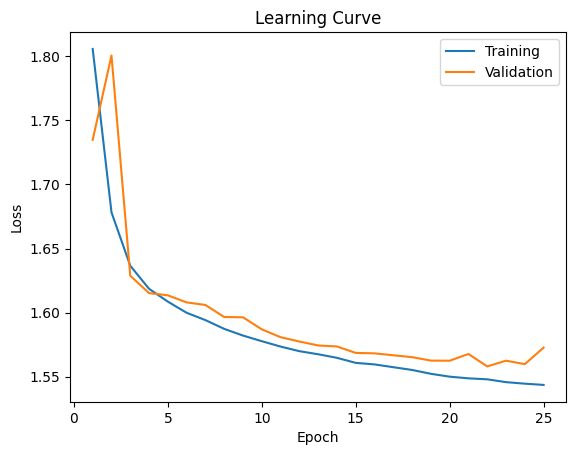

In [12]:
# Plot the training and validation loss over epochs
plt.plot(epoch_nums, training_loss, label="Training")  # Plot training loss
plt.plot(epoch_nums, validation_loss, label="Validation")  # Plot validation loss

# Label the x-axis as 'Epoch'
plt.xlabel("Epoch")

# Label the y-axis as 'Loss'
plt.ylabel("Loss")

# Add a legend to differentiate between training and validation loss
plt.legend(loc="upper right")

# Set the title of the plot
plt.title("Learning Curve")